# Deep Learning Overview

Deep learning is a category of machine learning. Machine learning is a category of artificial intelligence. Deep learning is the use of neural networks to do machine learning, like classify and regress data. This chapter provides an overview and we will dive further into these topics in later chapters.

The main advice I would give to beginners in deep learning are to focus less on the neurological inspired language (i.e., connections between neurons), and instead view deep learning as a series of linear algebra operations where many of the matrices are filled with adjustable parameters. Of course nonlinear functions (activations) are used to join the linear algebra operations, but deep learning is essentially linear algebra operations specified via a “computation network” (aka computation graph) that vaguely looks like neurons connected in a brain.


## 1. What is a neural network?

The deep in deep learning means we have many layers in our neural networks. What is a neural network? Without loss of generality, we can view neural networks as 2 components: (1) a nonlinear function $g(\cdot)$ which operates on our input features and outputs a new set of features $\mathbf{H}=g(\mathbf{X})$ and (2) a linear model like we saw in our Introduction to Machine Learning. Our model equation for deep learning regression is:
$$
\hat{y} = \vec{w}g(\vec{x}) + b
$$

In this case we do not choose features. We have replaced them with a set of trainable features $g(\vec{x})$ and then we use the same linear model as before. The problem es how to choose $g(\vec{x})$. It has to be **differentiable** and be composed of **layers**. Each layer must be also differentiable functions with **trainable weights** (free parameters). There are different types of layers, the most common ones are **dense** or **fully-connected** layers.

A dense layer is defined by two things: the desired **output feature shape** and the **activation**. The equation is:
$$
\vec{h} = \sigma(\mathbf{W}\vec{x}+\vec{b})
$$
where $\mathbf{W}$ is a trainable $F\times D$ matrix, where $D$ is the dimension of the input vector $\vec{x}$ and $F$ is the is the output vector dimension, $\vec{b}$ is a trainable $F$ dimensional vector, and $\sigma(\cdot)$ is the activation function. The number of features $F$ is *not* trainable, it is an **hyperparameter** that is problem dependent. The activation function must me non-linear, otherwise, subsequent applications of linear functions would result in a big matrix transformation that would essentially be a standar linear regression.

The most simple activation function is the **rectified linear unit (ReLU)**:
$$
\sigma(x) = \begin{cases}
                x, & \text{if} \quad x>0\\
                0, & \text{otherwise}
            \end{cases}
$$


### 1.1. Unviersal Approximation Theorem

Neural Networks can approximate any function given enough depth and width.

### 1.2. Frameworks

From now on we will be using Keras.



## 2. Data and modules

We will go back to the solubility example

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
# import dmol

2022-07-06 11:29:14.018338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 11:29:14.018355: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
# had to rehost because dataverse isn't reliable
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]
# standardize the features
soldata[feature_names] -= soldata[feature_names].mean()
soldata[feature_names] /= soldata[feature_names].std()

### 2.1. Preparing data for KERAS

In [8]:
full_data = tf.data.Dataset.from_tensor_slices(
    (soldata[feature_names].values, soldata["Solubility"].values)
)
N = len(soldata)
test_N = int(0.1 * N)
test_data = full_data.take(test_N).batch(16)
train_data = full_data.skip(test_N).batch(16)

2022-07-06 11:31:07.351150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 11:31:07.351622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 11:31:07.351705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-06 11:31:07.351759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-06 11:31:07.351808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

## 3. Building the Neural Network

Now we build our neural network model. In this case, our $g(\vec{x})=\sigma(\mathbf{W}\vec{x}+\vec{b}$. We will call this function
a hidden layer. This is because we do not observe its output. Remember, the solubility will be $\hat{y}=\vec{w}g(\vec{x})+b$. We choos the activation $\tanh{(\cdot)}$

In [9]:
# our hidden layer
# We only need to define the output dimension - 32.
hidden_layer = tf.keras.layers.Dense(32, activation="tanh")
# Last layer - which we want to output one number
# the predicted solubility.
output_layer = tf.keras.layers.Dense(1)

# Now we put the layers into a sequential model
model = tf.keras.Sequential()
model.add(hidden_layer)
model.add(output_layer)

# our model is complete

# Try out our model on first few datapoints
model(soldata[feature_names].values[:3])

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.20428604],
       [ 0.06481122],
       [-0.06915915]], dtype=float32)>

We can see our model predicting the solubility for 3 molecules above.

At this point, we’ve defined how our model structure should work and it can be called on data. Now we need to train it! We prepare the model for training by calling model.compile, which is where we define our optimization (typically a flavor of stochastic gradient descent) and loss

In [10]:
model.compile(optimizer="SGD", loss="mean_squared_error")

Look back to the amount of work it took to previously set-up loss and optimization process! Now we can train our model

In [11]:
model.fit(train_data, epochs=50)

Epoch 1/50
562/562 [==============================] - 1s 857us/step - loss: 2.1207
Epoch 2/50
562/562 [==============================] - 0s 866us/step - loss: 1.6504
Epoch 3/50
562/562 [==============================] - 1s 937us/step - loss: 1.5700
Epoch 4/50
562/562 [==============================] - 1s 894us/step - loss: 1.5231
Epoch 5/50
562/562 [==============================] - 0s 861us/step - loss: 1.4851
Epoch 6/50
562/562 [==============================] - 0s 822us/step - loss: 1.4494
Epoch 7/50
562/562 [==============================] - 0s 857us/step - loss: 1.4151
Epoch 8/50
562/562 [==============================] - 1s 887us/step - loss: 1.3872
Epoch 9/50
562/562 [==============================] - 0s 836us/step - loss: 1.3633
Epoch 10/50
562/562 [==============================] - 1s 891us/step - loss: 1.3475
Epoch 11/50
562/562 [==============================] - 0s 884us/step - loss: 1.3362
Epoch 12/50
562/562 [==============================] - 0s 866us/step - loss: 1.3270
E

For reference, we got a loss about as low as 3 in our previous work. It was also much faster, thanks to the optimizations. Now let’s see how our model did on the test data

In [21]:
# get model predictions on test data and get labels
# squeeze to remove extra dimensions
yhat = np.squeeze(model.predict(test_data))
test_y = soldata["Solubility"].values[:test_N]

63/63 [==============================] - 0s 1ms/step


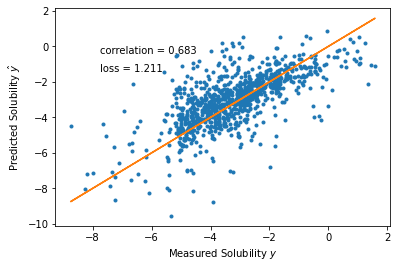

In [22]:
plt.plot(test_y, yhat, ".")
plt.plot(test_y, test_y, "-")
plt.xlabel("Measured Solubility $y$")
plt.ylabel("Predicted Solubility $\hat{y}$")
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.show()

This performance is better than our simple linear model.